In [2]:
import torch
torch.cuda.empty_cache()

In [3]:
!nvidia-smi

Mon May  6 01:24:27 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0              46W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [4]:
import os, shutil, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
import cv2
import time, datetime

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
cwd = os.getcwd()
path  = cwd
# dirname = '/content'
dirname = '/content/drive/MyDrive/Colab Notebooks/cse5717/data'

# Data Preparation
- divide the data into 10% and 90% into the training data

In [7]:
# raw data
origin_dir = os.path.join(dirname,'raw')

# processed data
base_dir = os.path.join(dirname, 'dataset')
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

os.makedirs(base_dir, exist_ok=True)
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

categories = os.listdir(origin_dir)
print(categories)

['metal', 'plastic', 'glass', 'paper', 'compost', 'trash', 'cardboard']


In [8]:
# # copy into train and test
# # only process once, comment out
# from sklearn.model_selection import train_test_split
#from PIL import Image

#for category in categories:
#     category_src_dir = os.path.join(origin_dir, category)
#     train_category_dst_dir = os.path.join(train_dir, category)
#     test_category_dst_dir = os.path.join(test_dir, category)
#     os.makedirs(train_category_dst_dir, exist_ok=True)
#     os.makedirs(test_category_dst_dir, exist_ok=True)

#     file_names = os.listdir(category_src_dir)
#     random.shuffle(file_names)
#     length = len(file_names)
#     train_file_names = file_names[:int(length*0.8)]
#     test_file_names = file_names[int(length*0.8):]

#     for name in train_file_names:
#         src_path = os.path.join(category_src_dir, name)
#         dst_path = os.path.join(train_category_dst_dir, name)
#         shutil.copyfile(src = src_path, dst = dst_path)

#     for name in test_file_names:
#         src_path = os.path.join(category_src_dir, name)
#         dst_path = os.path.join(test_category_dst_dir, name)
#         shutil.copyfile(src = src_path, dst = dst_path)

Training Data Counts:  {'metal': 252, 'plastic': 246, 'glass': 107, 'paper': 452, 'compost': 616, 'trash': 589, 'cardboard': 346}
Test Data Counts:  {'metal': 63, 'plastic': 62, 'glass': 27, 'paper': 113, 'compost': 155, 'trash': 148, 'cardboard': 87}


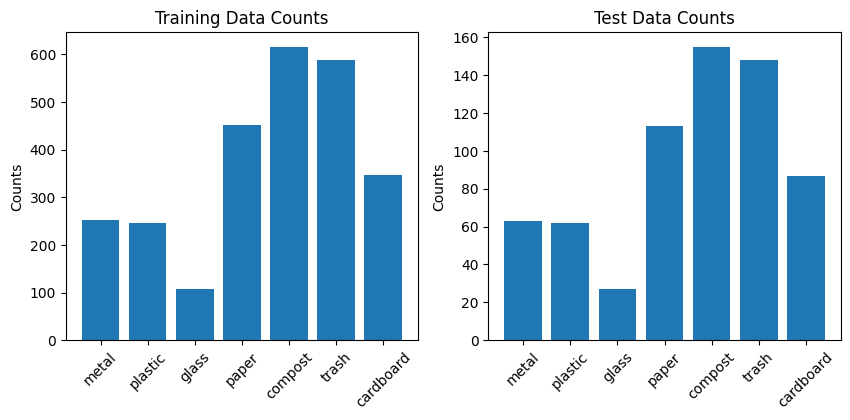

In [9]:
# plot data distribution
def count_images_in_categories(directory):
    category_counts = {}
    for category in os.listdir(directory):
        category_dir = os.path.join(directory, category)
        if os.path.isdir(category_dir):
            count = len([name for name in os.listdir(category_dir) if os.path.isfile(os.path.join(category_dir, name))])
            category_counts[category] = count
    return category_counts

train_counts = count_images_in_categories(train_dir)
test_counts = count_images_in_categories(test_dir)
print('Training Data Counts: ', train_counts)
print('Test Data Counts: ', test_counts)

fig, ax = plt.subplots(1,2, figsize=(10,4))

ax[0].bar(list(train_counts.keys()), list(train_counts.values()))
ax[0].set(title='Training Data Counts', ylabel='Counts')
ax[0].tick_params(axis='x', rotation=45)
ax[1].bar(list(test_counts.keys()), list(test_counts.values()))
ax[1].set(title='Test Data Counts', ylabel='Counts')
ax[1].tick_params(axis='x', rotation=45)
plt.show()

# Convolution Neural Network

## Base Model

In [79]:
# data preprocessing

from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255, validation_split = 0.2)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size = (256, 256),
    batch_size = 32,
    class_mode = 'categorical',
    subset = 'training', seed = 42)

validation_data = train_datagen.flow_from_directory(
    train_dir,
    target_size = (256, 256),
    batch_size = 32,
    class_mode = 'categorical',
    subset = 'validation', seed = 42)

Found 2079 images belonging to 7 classes.
Found 517 images belonging to 7 classes.


In [80]:
train_sample_count = train_data.samples
validation_sample_count = validation_data.samples
print(train_sample_count, validation_sample_count)

2079 517


In [81]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

tf.keras.backend.clear_session()

cnn_model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(256,256,3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),   # dropout for regularization
    Dense(7, activation='softmax')
])

cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 128)       0

In [82]:
start = time.time()
cnn_model.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

cnn_history = cnn_model.fit(
    train_data,
    epochs=10,
    validation_data=validation_data
)
end = time.time()
print(f'Time taken : {end - start}')

Epoch 1/10
65/65 [==============================] - 58s 891ms/step - loss: 2.8421 - accuracy: 0.3175 - val_loss: 1.7110 - val_accuracy: 0.3578
Epoch 2/10
65/65 [==============================] - 57s 876ms/step - loss: 1.5553 - accuracy: 0.4315 - val_loss: 2.1146 - val_accuracy: 0.3559
Epoch 3/10
65/65 [==============================] - 56s 855ms/step - loss: 1.3698 - accuracy: 0.5147 - val_loss: 1.6856 - val_accuracy: 0.4139
Epoch 4/10
65/65 [==============================] - 56s 866ms/step - loss: 1.1948 - accuracy: 0.5859 - val_loss: 1.9932 - val_accuracy: 0.3888
Epoch 5/10
65/65 [==============================] - 56s 866ms/step - loss: 1.0534 - accuracy: 0.6291 - val_loss: 1.6739 - val_accuracy: 0.4565
Epoch 6/10
65/65 [==============================] - 57s 875ms/step - loss: 0.8932 - accuracy: 0.7027 - val_loss: 1.7086 - val_accuracy: 0.4623
Epoch 7/10
65/65 [==============================] - 57s 887ms/step - loss: 0.6261 - accuracy: 0.7792 - val_loss: 1.7946 - val_accuracy: 0.4565

In [83]:
# test data processor

test_datagen  = ImageDataGenerator(rescale = 1./255)
test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size = (256, 256),
    batch_size = 32,
    class_mode = 'categorical',
    seed = 42)

Found 652 images belonging to 7 classes.


In [84]:
test_loss_cnn, test_accuracy_cnn = cnn_model.evaluate(test_data)
print(f'CNN Model Test Accuracy : {test_accuracy_cnn}')

21/21 [==============================] - 14s 648ms/step - loss: 1.6953 - accuracy: 0.6135
CNN Model Test Accuracy : 0.6134969592094421


## Base Model with Data Augmentation



In [16]:
# data preprocessing
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size = (256, 256),
    batch_size = 32,
    class_mode = 'categorical',
    subset = 'training', seed = 42)

validation_data = validation_datagen.flow_from_directory(
    train_dir,
    target_size = (256, 256),
    batch_size = 32,
    class_mode = 'categorical',
    subset = 'validation', seed = 42)

Found 2079 images belonging to 7 classes.
Found 517 images belonging to 7 classes.


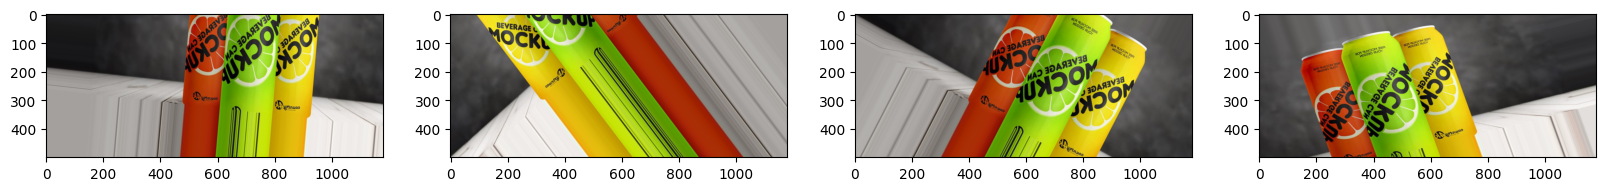

In [28]:
# disaply sample augmented image

from PIL import Image
from keras.preprocessing import image

fnames = [os.path.join(train_dir, fname) for fname in os.listdir(train_dir)]
filenames = [os.path.join(fnames[0], filename) for filename in os.listdir(fnames[0])]

img_path = os.path.join(train_dir, fnames[0], filenames[0]) # sample image to augment
img =Image.open(img_path)

x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)

plt.figure(figsize=(20,20))
i=0
for batch in train_datagen.flow(x, batch_size=1):
    ax = plt.subplot(1, 4, i+1)
    plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

In [29]:
# apply the same model

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

tf.keras.backend.clear_session()

cnn_model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(256,256,3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),   # dropout for regularization
    Dense(7, activation='softmax')
])

cnn_model.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

start = time.time()
cnn_history = cnn_model.fit(
    train_data,
    epochs=10,
    validation_data=validation_data
)
end = time.time()
print(f'Time taken : {end - start}')

Epoch 1/10
 1/65 [..............................] - ETA: 2:23 - loss: 1.9891 - accuracy: 0.0938

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


65/65 [==============================] - 83s 1s/step - loss: 2.1805 - accuracy: 0.2872 - val_loss: 1.7014 - val_accuracy: 0.3830
Epoch 2/10
65/65 [==============================] - 82s 1s/step - loss: 1.6356 - accuracy: 0.3891 - val_loss: 1.6111 - val_accuracy: 0.3868
Epoch 3/10
65/65 [==============================] - 83s 1s/step - loss: 1.5272 - accuracy: 0.4286 - val_loss: 1.5919 - val_accuracy: 0.3946
Epoch 4/10
65/65 [==============================] - 81s 1s/step - loss: 1.4509 - accuracy: 0.4772 - val_loss: 1.5736 - val_accuracy: 0.4004
Epoch 5/10
65/65 [==============================] - 82s 1s/step - loss: 1.3953 - accuracy: 0.4897 - val_loss: 1.8786 - val_accuracy: 0.3791
Epoch 6/10
65/65 [==============================] - 85s 1s/step - loss: 1.3593 - accuracy: 0.5065 - val_loss: 1.6732 - val_accuracy: 0.4004
Epoch 7/10
65/65 [==============================] - 80s 1s/step - loss: 1.2905 - accuracy: 0.5281 - val_loss: 1.6568 - val_accuracy: 0.4545
Epoch 8/10
65/65 [=============

In [39]:
test_data.reset() # reset the iteration
test_loss_cnn, test_accuracy_cnn = cnn_model.evaluate(test_data)
print(f'CNN Model with Data Augmetantation, Test Accuracy : {test_accuracy_cnn}')

 3/21 [===>..........................] - ETA: 18s - loss: 1.1375 - accuracy: 0.5833

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


21/21 [==============================] - 14s 655ms/step - loss: 1.1169 - accuracy: 0.5844
CNN Model with Data Augmetantation, Test Accuracy : 0.5843558311462402


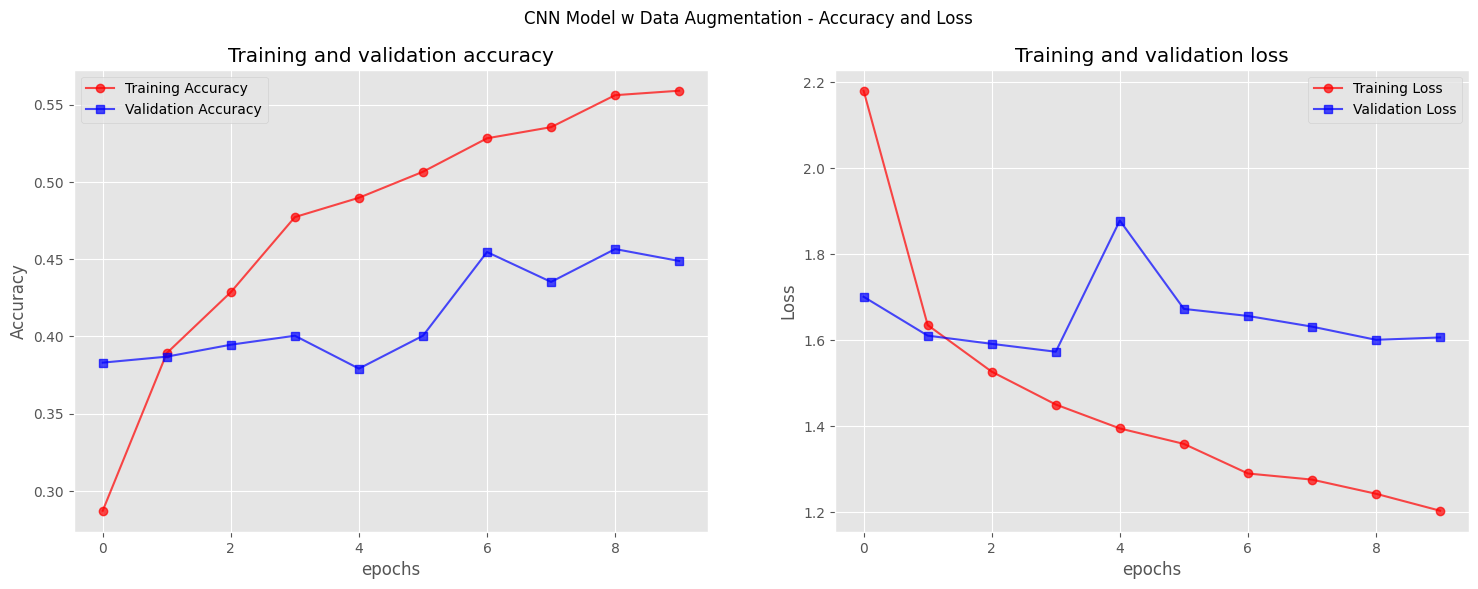

In [38]:
acc = cnn_history.history['accuracy']
val_acc = cnn_history.history['val_accuracy']
loss = cnn_history.history['loss']
val_loss = cnn_history.history['val_loss']

epochs = range(len(acc))
plt.style.use('ggplot')

fig, ax = plt.subplots(1,2, figsize=(18,6))
plt.suptitle('CNN Model w Data Augmentation - Accuracy and Loss')

ax[0].plot(epochs, acc, 'ro-', label='Training Accuracy', alpha=0.7)
ax[0].plot(epochs, val_acc, 'bs-', label='Validation Accuracy', alpha=0.7)
ax[0].set(title='Training and validation accuracy', xlabel='epochs', ylabel='Accuracy')
ax[0].legend()

ax[1].plot(epochs, loss, 'ro-', label='Training Loss', alpha=0.7)
ax[1].plot(epochs, val_loss, 'bs-', label='Validation Loss', alpha=0.7)
ax[1].set(title='Training and validation loss', xlabel='epochs', ylabel='Loss')
ax[1].legend()

plt.show()

# Xception Model




## Data Augmentation w/o Selective Layer Training

In [40]:
from keras.applications.xception import Xception, preprocess_input
from keras import optimizers, callbacks
from keras.layers import Input, GlobalAveragePooling2D, Dense

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input, # model-specific preprocessor instead of rescale
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rescale=1./255,
    validation_split=0.2
)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size = (256, 256),
    batch_size = 32,
    class_mode = 'categorical',
    subset = 'training', seed = 42)

validation_data = validation_datagen.flow_from_directory(
    train_dir,
    target_size = (256, 256),
    batch_size = 32,
    class_mode = 'categorical',
    subset = 'validation', seed = 42)

Found 2079 images belonging to 7 classes.
Found 517 images belonging to 7 classes.


In [41]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=(256,256,3))
base_model.trainable = False # use pre-trained features as-is

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
output = Dense(7, activation='softmax')(x)

xception_model = keras.Model(inputs=base_model.input, outputs=output)
optimizer = optimizers.SGD(learning_rate = 0.01, momentum = 0.9)

xception_model.compile(
    optimizer = optimizer,
    loss = 'categorical_crossentropy',
    metrics = 'accuracy'
)
start = time.time()
history = xception_model.fit(
    train_data,
    steps_per_epoch=train_data.samples // train_data.batch_size,
    epochs = 10,
    validation_data = validation_data,
    validation_steps=validation_data.samples // validation_data.batch_size
)
end = time.time()
print(f'Time taken : {end - start}')

83683744/83683744 [==============================] - 5s 0us/step
Epoch 1/10
64/64 [==============================] - 86s 1s/step - loss: 0.8587 - accuracy: 0.7030 - val_loss: 1.9582 - val_accuracy: 0.2227
Epoch 2/10
64/64 [==============================] - 82s 1s/step - loss: 0.4330 - accuracy: 0.8530 - val_loss: 1.9303 - val_accuracy: 0.1875
Epoch 3/10
64/64 [==============================] - 81s 1s/step - loss: 0.3465 - accuracy: 0.8784 - val_loss: 1.9606 - val_accuracy: 0.1797
Epoch 4/10
64/64 [==============================] - 81s 1s/step - loss: 0.2969 - accuracy: 0.8930 - val_loss: 1.9665 - val_accuracy: 0.1660
Epoch 5/10
64/64 [==============================] - 80s 1s/step - loss: 0.2501 - accuracy: 0.9130 - val_loss: 1.9692 - val_accuracy: 0.1445
Epoch 6/10
64/64 [==============================] - 81s 1s/step - loss: 0.2172 - accuracy: 0.9292 - val_loss: 1.9565 - val_accuracy: 0.1875
Epoch 7/10
64/64 [==============================] - 82s 1s/step - loss: 0.2107 - accuracy: 0.93

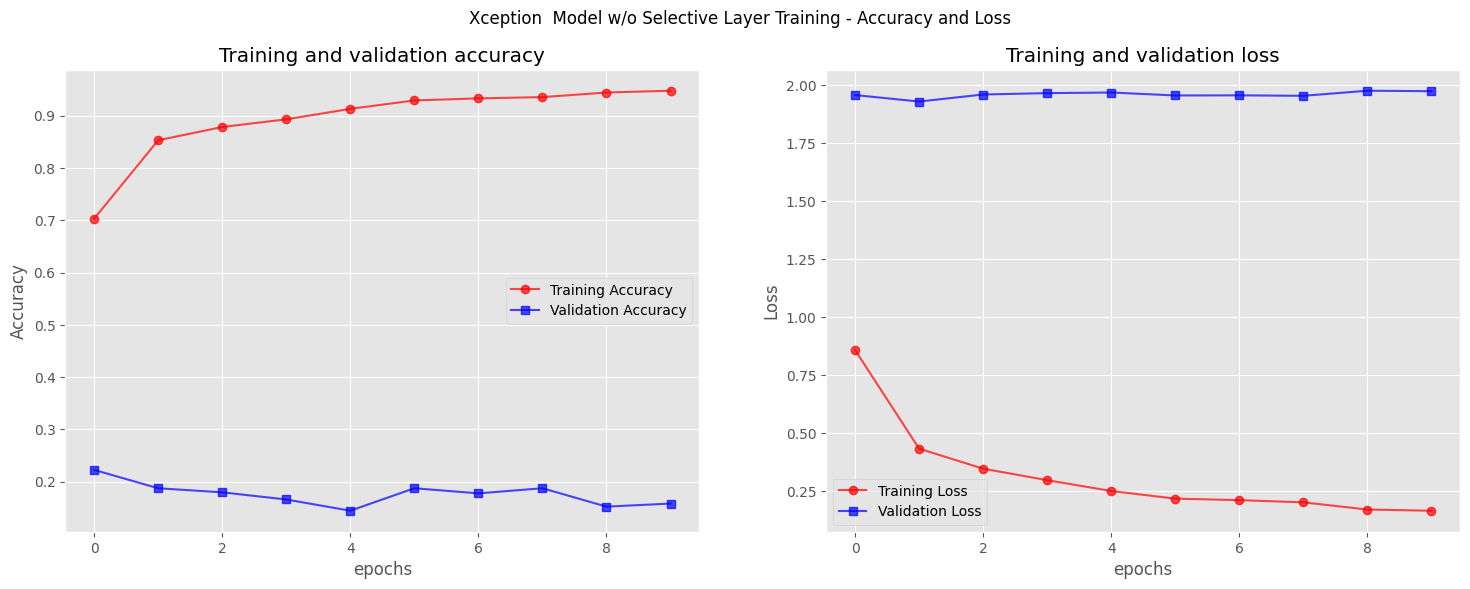

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

fig, ax = plt.subplots(1,2, figsize=(18,6))
plt.suptitle('Xception  Model w/o Selective Layer Training - Accuracy and Loss')

ax[0].plot(epochs, acc, 'ro-', label='Training Accuracy', alpha=0.7)
ax[0].plot(epochs, val_acc, 'bs-', label='Validation Accuracy', alpha=0.7)
ax[0].set(title='Training and validation accuracy', xlabel='epochs', ylabel='Accuracy')
ax[0].legend()

ax[1].plot(epochs, loss, 'ro-', label='Training Loss', alpha=0.7)
ax[1].plot(epochs, val_loss, 'bs-', label='Validation Loss', alpha=0.7)
ax[1].set(title='Training and validation loss', xlabel='epochs', ylabel='Loss')
ax[1].legend()

plt.show()

In [43]:
test_data.reset()

test_loss_xception, test_accuracy_xception = xception_model.evaluate(test_data)
y_predictions_Xception = xception_model.predict(test_data)

print(f'Xception Model Test Accuracy : {test_accuracy_xception}')

15/21 [====================>.........] - ETA: 3s - loss: 0.3904 - accuracy: 0.8583

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


21/21 [==============================] - 16s 682ms/step
Xception Model Test Accuracy : 0.8634969592094421


## Data Augmentation w/ Selective Layer Training


In [44]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=(256,256,3))
base_model.trainable = True # use pre-trained features as-is

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
output = Dense(7, activation='softmax')(x)

xception_model_True = keras.Model(inputs=base_model.input, outputs=output)
optimizer = optimizers.SGD(learning_rate = 0.01, momentum = 0.9)

xception_model_True.compile(
    optimizer = optimizer,
    loss = 'categorical_crossentropy',
    metrics = 'accuracy'
)
start = time.time()
history = xception_model_True.fit(
    train_data,
    steps_per_epoch=train_data.samples // train_data.batch_size,
    epochs = 10,
    validation_data = validation_data,
    validation_steps=validation_data.samples // validation_data.batch_size
)
end = time.time()
print(f'Time taken : {end - start}')

Epoch 1/10
64/64 [==============================] - 98s 1s/step - loss: 0.9844 - accuracy: 0.6566 - val_loss: 2.0028 - val_accuracy: 0.2227
Epoch 2/10
64/64 [==============================] - 82s 1s/step - loss: 0.3505 - accuracy: 0.8813 - val_loss: 2.0246 - val_accuracy: 0.2266
Epoch 3/10
64/64 [==============================] - 80s 1s/step - loss: 0.2015 - accuracy: 0.9414 - val_loss: 2.0031 - val_accuracy: 0.0977
Epoch 4/10
64/64 [==============================] - 81s 1s/step - loss: 0.1319 - accuracy: 0.9546 - val_loss: 2.0207 - val_accuracy: 0.0957
Epoch 5/10
64/64 [==============================] - 81s 1s/step - loss: 0.1100 - accuracy: 0.9648 - val_loss: 1.9966 - val_accuracy: 0.1699
Epoch 6/10
64/64 [==============================] - 82s 1s/step - loss: 0.0739 - accuracy: 0.9746 - val_loss: 2.0591 - val_accuracy: 0.0957
Epoch 7/10
64/64 [==============================] - 81s 1s/step - loss: 0.0673 - accuracy: 0.9766 - val_loss: 2.0357 - val_accuracy: 0.1016
Epoch 8/10
64/64 [==

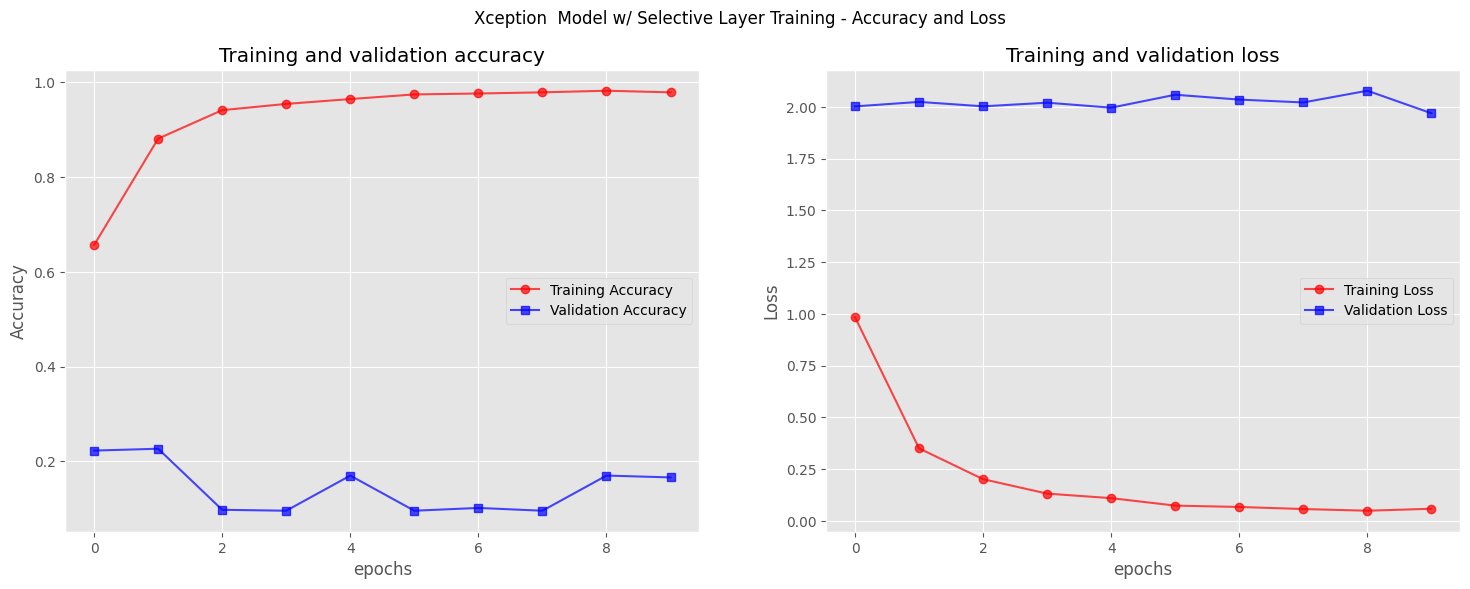

In [45]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

fig, ax = plt.subplots(1,2, figsize=(18,6))
plt.suptitle('Xception  Model w/ Selective Layer Training - Accuracy and Loss')

ax[0].plot(epochs, acc, 'ro-', label='Training Accuracy', alpha=0.7)
ax[0].plot(epochs, val_acc, 'bs-', label='Validation Accuracy', alpha=0.7)
ax[0].set(title='Training and validation accuracy', xlabel='epochs', ylabel='Accuracy')
ax[0].legend()

ax[1].plot(epochs, loss, 'ro-', label='Training Loss', alpha=0.7)
ax[1].plot(epochs, val_loss, 'bs-', label='Validation Loss', alpha=0.7)
ax[1].set(title='Training and validation loss', xlabel='epochs', ylabel='Loss')
ax[1].legend()

plt.show()

In [46]:
test_data.reset()

test_loss_xception, test_accuracy_xception = xception_model_True.evaluate(test_data)
y_predictions_Xception_False = xception_model.predict(test_data)

21/21 [==============================] - 14s 685ms/step


## Feature Extraction

In [47]:
from keras.applications.xception import Xception, preprocess_input
from keras import optimizers, callbacks
from keras.layers import Input, GlobalAveragePooling2D, Dense

batch_size = 1
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size = (256, 256),
    batch_size = batch_size,
    class_mode = 'categorical',
    subset = 'training', seed = 42)

validation_data = train_datagen.flow_from_directory(
    train_dir,
    target_size = (256, 256),
    batch_size = batch_size,
    class_mode = 'categorical',
    subset = 'validation', seed = 42)

Found 2079 images belonging to 7 classes.
Found 517 images belonging to 7 classes.


In [51]:
from keras.layers import Input, Flatten, Dense, Dropout
from keras.applications import VGG16
from keras.optimizers import Adam

keras.backend.clear_session()

base_model = Xception(weights='imagenet', include_top=False, input_shape=(256,256,3))
base_model.trainable = False # use pre-trained features as-is

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 8, 8, 2048))
    labels = np.zeros(shape=(sample_count, 7))
    generator = train_data
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = base_model.predict(inputs_batch, verbose=0)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

start = time.time()
train_features, train_labels = extract_features(train_dir, train_sample_count)
validation_features, validation_labels = extract_features(train_dir, validation_sample_count)
end = time.time()
print(f'Time taken : {end - start}')

train_features_reshaped = np.reshape(train_features, (train_sample_count, 8 * 8* 2048))
validation_features_reshaped = np.reshape(validation_features, (validation_sample_count, 8 * 8* 2048))

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Time taken : 229.9444878101349


In [52]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import optimizers

xception_model_fe = Sequential([
    Dense(256, activation='relu', input_dim=8*8*2048),
    Dropout(0.5),
    Dense(7, activation='softmax')
])

xception_model_fe.compile(optimizer=optimizers.RMSprop(learning_rate=2e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

xception_model_fe.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               33554688  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 7)                 1799      
                                                                 
Total params: 33556487 (128.01 MB)
Trainable params: 33556487 (128.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [53]:
start = time.time()
history = xception_model_fe.fit(
    train_features_reshaped, train_labels,
    epochs=20,
    batch_size=20,
    validation_data=(validation_features_reshaped, validation_labels))
end = time.time()
print(f'Time taken : {end - start}')

Epoch 1/20
104/104 [==============================] - 2s 13ms/step - loss: 0.6461 - accuracy: 0.7816 - val_loss: 0.2619 - val_accuracy: 0.9052
Epoch 2/20
104/104 [==============================] - 1s 7ms/step - loss: 0.2374 - accuracy: 0.9230 - val_loss: 0.1404 - val_accuracy: 0.9613
Epoch 3/20
104/104 [==============================] - 1s 7ms/step - loss: 0.1142 - accuracy: 0.9577 - val_loss: 0.1027 - val_accuracy: 0.9729
Epoch 4/20
104/104 [==============================] - 1s 7ms/step - loss: 0.0765 - accuracy: 0.9764 - val_loss: 0.0915 - val_accuracy: 0.9768
Epoch 5/20
104/104 [==============================] - 1s 7ms/step - loss: 0.0504 - accuracy: 0.9865 - val_loss: 0.1055 - val_accuracy: 0.9749
Epoch 6/20
104/104 [==============================] - 1s 7ms/step - loss: 0.0382 - accuracy: 0.9861 - val_loss: 0.0750 - val_accuracy: 0.9845
Epoch 7/20
104/104 [==============================] - 1s 7ms/step - loss: 0.0304 - accuracy: 0.9899 - val_loss: 0.0865 - val_accuracy: 0.9768
Epoch

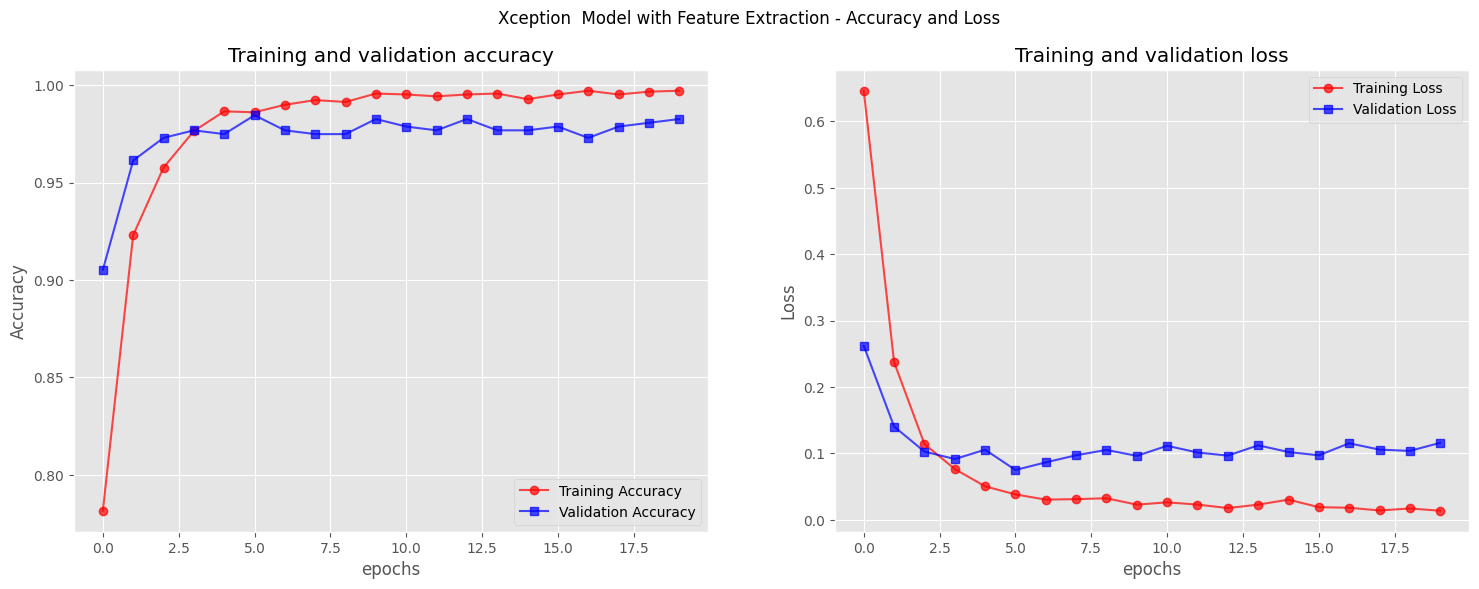

In [54]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

fig, ax = plt.subplots(1,2, figsize=(18,6))
plt.suptitle('Xception  Model with Feature Extraction - Accuracy and Loss')

ax[0].plot(epochs, acc, 'ro-', label='Training Accuracy', alpha=0.7)
ax[0].plot(epochs, val_acc, 'bs-', label='Validation Accuracy', alpha=0.7)
ax[0].set(title='Training and validation accuracy', xlabel='epochs', ylabel='Accuracy')
ax[0].legend()

ax[1].plot(epochs, loss, 'ro-', label='Training Loss', alpha=0.7)
ax[1].plot(epochs, val_loss, 'bs-', label='Validation Loss', alpha=0.7)
ax[1].set(title='Training and validation loss', xlabel='epochs', ylabel='Loss')
ax[1].legend()

plt.show()

In [55]:
# test data
batch_size = 1

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(256,256),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_sample_count = test_data.samples # test=652

test_features, test_labels = extract_features(test_dir, test_sample_count)
test_features_reshaped = np.reshape(test_features, (test_sample_count, 8 * 8 * 2048))

Found 652 images belonging to 7 classes.


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [56]:
test_loss, test_accuracy = xception_model_fe.evaluate(test_features_reshaped, test_labels)
print(f'Xception Model with Feature Extraction, Test Accuracy : {test_accuracy}')

21/21 [==============================] - 0s 6ms/step - loss: 0.1349 - accuracy: 0.9770
Xception Model with Feature Extraction, Test Accuracy : 0.9769938588142395


# VGG16 Model with Feature Extraction

In [60]:
from keras.layers import Input, Flatten, Dense, Dropout
from keras.applications import VGG16
from keras.optimizers import Adam

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
# base_model.summary()

58889256/58889256 [==============================] - 4s 0us/step


In [62]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input

batch_size = 1

train_datagen = ImageDataGenerator(
    # rescale = 1./255,
    preprocessing_function=preprocess_input,
    validation_split = 0.2)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size = (256, 256),
    batch_size = batch_size,
    class_mode = 'categorical',
    subset = 'training', seed = 42)

validation_data = train_datagen.flow_from_directory(
    train_dir,
    target_size = (256, 256),
    batch_size = batch_size,
    class_mode = 'categorical',
    subset = 'validation', seed = 42)

Found 2079 images belonging to 7 classes.
Found 517 images belonging to 7 classes.


In [63]:
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 8, 8, 512))
    labels = np.zeros(shape=(sample_count, 7))
    generator = train_data
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = base_model.predict(inputs_batch, verbose=0)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

start = time.time()
train_features, train_labels = extract_features(train_dir, train_sample_count)
validation_features, validation_labels = extract_features(train_dir, validation_sample_count)
end = time.time()
print(f'Time taken : {end - start}')

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Time taken : 220.47628450393677


In [64]:
train_features_reshaped = np.reshape(train_features, (train_sample_count, 8 * 8* 512))
validation_features_reshaped = np.reshape(validation_features, (validation_sample_count, 8 * 8* 512))

In [65]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import optimizers

VGG16_model = Sequential([
    Dense(256, activation='relu', input_dim=8*8*512),
    Dropout(0.5),
    Dense(7, activation='softmax')
])

VGG16_model.compile(optimizer=optimizers.RMSprop(learning_rate=2e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

VGG16_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 256)               8388864   
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 7)                 1799      
                                                                 
Total params: 8390663 (32.01 MB)
Trainable params: 8390663 (32.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [66]:
start = time.time()
history = VGG16_model.fit(
    train_features_reshaped, train_labels,
    epochs=20,
    batch_size=20,
    validation_data=(validation_features_reshaped, validation_labels))
end = time.time()
print(f'Time taken : {end - start}')

Epoch 1/20
104/104 [==============================] - 1s 7ms/step - loss: 9.5438 - accuracy: 0.4666 - val_loss: 1.5172 - val_accuracy: 0.8317
Epoch 2/20
104/104 [==============================] - 0s 4ms/step - loss: 3.2952 - accuracy: 0.7104 - val_loss: 0.5354 - val_accuracy: 0.9168
Epoch 3/20
104/104 [==============================] - 0s 4ms/step - loss: 1.7607 - accuracy: 0.7994 - val_loss: 0.2069 - val_accuracy: 0.9652
Epoch 4/20
104/104 [==============================] - 0s 4ms/step - loss: 1.0434 - accuracy: 0.8543 - val_loss: 0.0671 - val_accuracy: 0.9826
Epoch 5/20
104/104 [==============================] - 0s 4ms/step - loss: 0.5982 - accuracy: 0.9091 - val_loss: 0.0428 - val_accuracy: 0.9923
Epoch 6/20
104/104 [==============================] - 0s 4ms/step - loss: 0.4540 - accuracy: 0.9298 - val_loss: 0.0206 - val_accuracy: 0.9961
Epoch 7/20
104/104 [==============================] - 0s 4ms/step - loss: 0.4204 - accuracy: 0.9226 - val_loss: 0.0217 - val_accuracy: 0.9961
Epoch 

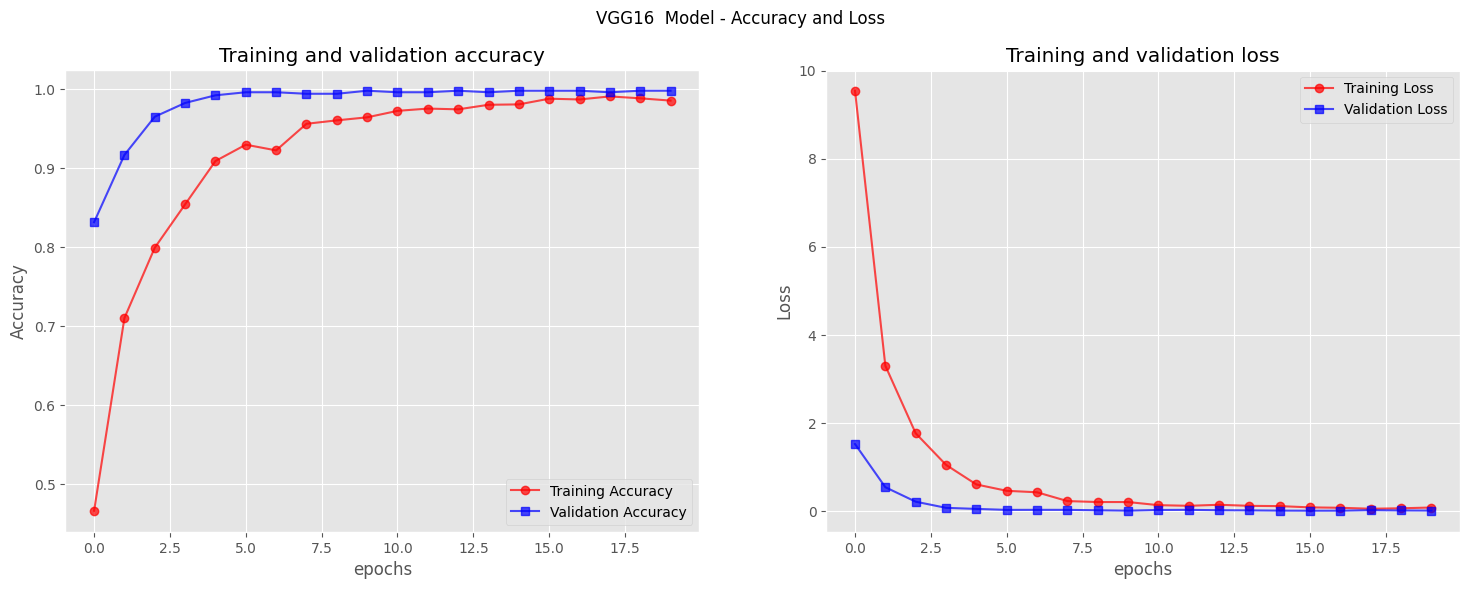

In [67]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

fig, ax = plt.subplots(1,2, figsize=(18,6))
plt.suptitle('VGG16  Model - Accuracy and Loss')

ax[0].plot(epochs, acc, 'ro-', label='Training Accuracy', alpha=0.7)
ax[0].plot(epochs, val_acc, 'bs-', label='Validation Accuracy', alpha=0.7)
ax[0].set(title='Training and validation accuracy', xlabel='epochs', ylabel='Accuracy')
ax[0].legend()

ax[1].plot(epochs, loss, 'ro-', label='Training Loss', alpha=0.7)
ax[1].plot(epochs, val_loss, 'bs-', label='Validation Loss', alpha=0.7)
ax[1].set(title='Training and validation loss', xlabel='epochs', ylabel='Loss')
ax[1].legend()

plt.show()

In [68]:
# test data

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(256,256),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_features, test_labels = extract_features(test_dir, test_sample_count)
test_features_reshaped = np.reshape(test_features, (test_sample_count, 8 * 8 * 512))

Found 652 images belonging to 7 classes.


In [69]:
test_loss, test_accuracy = VGG16_model.evaluate(test_features_reshaped, test_labels)
print(f'VGG16 Model with Feature Extraction, Test Accuracy : {test_accuracy}')

21/21 [==============================] - 0s 3ms/step - loss: 0.0088 - accuracy: 0.9969
VGG16 Model with Feature Extraction, Test Accuracy : 0.9969325065612793


# ResNet50 Model with Feature Extraction


In [ ]:
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(256,256,3)
)

base_model.summary()

### Data Preprocessing

In [71]:
# Try 1 - ResNet50 without data augmentation, without feature extraction did not show much improvement
# Try 2 - ResNet50 without data augementation, feature extraction

batch_size = 1

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split = 0.2
)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    class_mode = 'categorical',
    subset = 'training',
    batch_size=batch_size,
    seed=42
)

validation_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    class_mode = 'categorical',
    subset = 'validation',
    batch_size=batch_size,
    seed=42
)

Found 2079 images belonging to 7 classes.
Found 517 images belonging to 7 classes.


### Feature Extraction

In [72]:
# feature extration for resnet50

def extract_features(generator, sample_count):
    features = np.zeros(shape=(sample_count, 8, 8, 2048))
    labels = np.zeros(shape=(sample_count, 7))
    generator = train_data
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = base_model.predict(inputs_batch, verbose=0)
        features[i * batch_size : i * batch_size + inputs_batch.shape[0]] = features_batch
        labels[i * batch_size : i * batch_size + inputs_batch.shape[0]] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

start = time.time()
train_features, train_labels = extract_features(train_data, train_sample_count)
validation_features, validation_labels = extract_features(validation_data, validation_sample_count)
end = time.time()
print(f'Time taken : {end - start}')

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Time taken : 239.65403270721436


In [73]:
train_features_reshaped = np.reshape(train_features, (train_sample_count, 8 * 8 * 2048))
validation_features_reshaped = np.reshape(validation_features, (validation_sample_count, 8 * 8 * 2048))

## Model Training

In [74]:
from keras.layers import Dense, Dropout

# freeze layers
# for layer in base_model.layers:
#   layer.trainable = False
tf.keras.backend.clear_session()

resnet_model = Sequential([
    Dense(256, activation='relu', input_shape=(8*8*2048, )),
    Dropout(0.5),
    Dense(7, activation='softmax')
])

optimizer = optimizers.Adam(learning_rate=1e-5)
# optimizer = optimizers.RMSprop(learning_rate=1e-3)
resnet_model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics='accuracy')

resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               33554688  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 7)                 1799      
                                                                 
Total params: 33556487 (128.01 MB)
Trainable params: 33556487 (128.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [75]:
start = time.time()
history = resnet_model.fit(
    train_features_reshaped, train_labels,
    epochs=20,
    validation_data=(validation_features_reshaped, validation_labels)
)
end = time.time()
print(f'Time taken : {end - start}')

Epoch 1/20
65/65 [==============================] - 2s 20ms/step - loss: 1.6530 - accuracy: 0.5854 - val_loss: 0.2393 - val_accuracy: 0.9265
Epoch 2/20
65/65 [==============================] - 1s 10ms/step - loss: 0.3727 - accuracy: 0.8730 - val_loss: 0.0906 - val_accuracy: 0.9710
Epoch 3/20
65/65 [==============================] - 1s 10ms/step - loss: 0.1882 - accuracy: 0.9404 - val_loss: 0.0365 - val_accuracy: 0.9961
Epoch 4/20
65/65 [==============================] - 1s 10ms/step - loss: 0.1198 - accuracy: 0.9610 - val_loss: 0.0214 - val_accuracy: 0.9961
Epoch 5/20
65/65 [==============================] - 1s 10ms/step - loss: 0.0788 - accuracy: 0.9769 - val_loss: 0.0154 - val_accuracy: 0.9961
Epoch 6/20
65/65 [==============================] - 1s 10ms/step - loss: 0.0640 - accuracy: 0.9822 - val_loss: 0.0071 - val_accuracy: 0.9981
Epoch 7/20
65/65 [==============================] - 1s 10ms/step - loss: 0.0598 - accuracy: 0.9846 - val_loss: 0.0072 - val_accuracy: 0.9981
Epoch 8/20
65

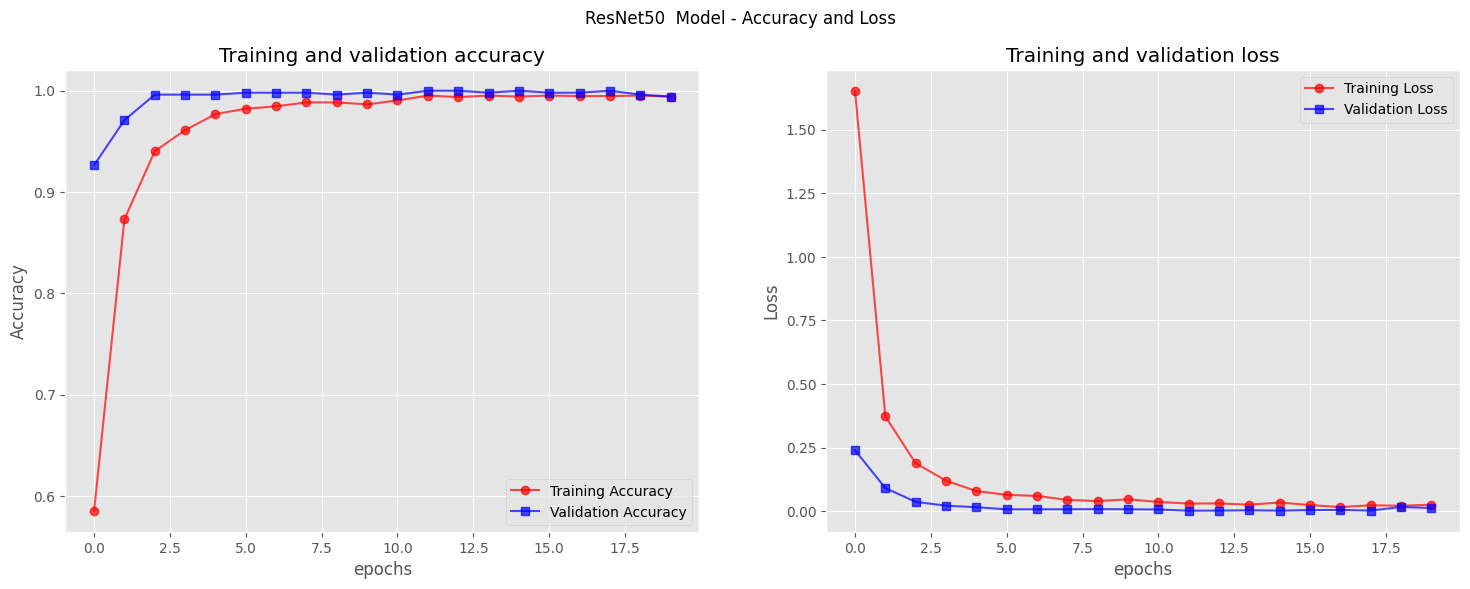

In [76]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

fig, ax = plt.subplots(1,2, figsize=(18,6))
plt.suptitle('ResNet50 Model - Accuracy and Loss')

ax[0].plot(epochs, acc, 'ro-', label='Training Accuracy', alpha=0.7)
ax[0].plot(epochs, val_acc, 'bs-', label='Validation Accuracy', alpha=0.7)
ax[0].set(title='Training and validation accuracy', xlabel='epochs', ylabel='Accuracy')
ax[0].legend()

ax[1].plot(epochs, loss, 'ro-', label='Training Loss', alpha=0.7)
ax[1].plot(epochs, val_loss, 'bs-', label='Validation Loss', alpha=0.7)
ax[1].set(title='Training and validation loss', xlabel='epochs', ylabel='Loss')
ax[1].legend()

plt.show()

In [77]:
# test data
batch_size = 1

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(256,256),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_features, test_labels = extract_features(test_dir, test_sample_count)
test_features_reshaped = np.reshape(test_features, (test_sample_count, 8 * 8 * 2048))

Found 652 images belonging to 7 classes.


In [78]:
test_loss, test_accuracy = resnet_model.evaluate(test_features_reshaped, test_labels)
print(f'ResNet50 Model with Feature Extraction, Test Accuracy : {test_accuracy}')

21/21 [==============================] - 0s 6ms/step - loss: 0.0087 - accuracy: 0.9969
ResNet50 Model with Feature Extraction, Test Accuracy : 0.9969325065612793
